### Импорт библиотек

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

/Users/nad/miniconda3/envs/sna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Испорт функций

In [2]:
from funcs.simple_classifier_funcs import get_embeddings, train_graph_randomforestclassifier2

### Обработка графа
Загружаем данные и удаляем самую большую компоненту

In [3]:
import os
os.chdir('../..')

In [4]:
# filename = 'data/graph_full.txt'
filename = 'data/graph_collapse.txt'

G = nx.Graph()

with open(filename, 'r') as file:
    for line in file:
        node1, node2 = line.strip().split()
        G.add_edge(node1, node2)

df = pd.read_csv('data/graph_collapse_node_traits_2.txt', delimiter='\t')

node_family_dict = df.set_index('node')['fam'].to_dict()
unique_fams = set(node_family_dict.values())
print(f"Number of unique families: {len(unique_fams)}")

# Удаление самой большой компоненты связности
components = list(nx.connected_components(G))
largest_component = max(components, key=len)
for node in largest_component:
    G.remove_node(node)
print(f"Number of components: {len(components) - 1}")

Number of unique families: 14
Number of components: 759


### Получаем эмбеддинги

In [5]:
# families = ['DNA/HAT', 'DNA/MuDR', 'Helitron', 'LINE', 'LTR/Copia']
families = ['Helitron', 'LINE']
G_not_full = G.copy()
for node in G.nodes():
    if node_family_dict[node] not in families:
        G_not_full.remove_node(node)

In [6]:
import pickle
# Проверяем, существует ли файл с эмбеддингами
file_path = 'data/node2vec_embeddings3.pkl'
if os.path.exists(file_path):
    # Если файл существует, загружаем эмбеддинги из файла
    print("Чтение...")
    with open(file_path, "rb") as f:
        node_embeddings = pickle.load(f)
else:
    # Если файл отсутствует, генерируем эмбеддинги
    node_embeddings = get_embeddings(G_not_full, 50)
    # Сохраняем эмбеддинги в файл
    print("Сохранение...")
    with open(file_path, 'wb') as f:  
        pickle.dump(node_embeddings, f)
print("Завершено")


Чтение...
Завершено


#### Сохраняем эмбеддинги

In [7]:
import pickle
# Проверяем, существует ли файл с эмбеддингами
file_path = 'data/node2vec_embeddings4.pkl'
if os.path.exists(file_path):
    # Если файл существует, загружаем эмбеддинги из файла
    print("Чтение...")
    with open(file_path, "rb") as f:
        node_embeddings2 = pickle.load(f)
else:
    # Если файл отсутствует, генерируем эмбеддинги
    node_embeddings2 = get_embeddings(G_not_full, 50)
    # Сохраняем эмбеддинги в файл
    print("Сохранение...")
    with open(file_path, 'wb') as f:  
        pickle.dump(node_embeddings2, f)
print("Завершено")


Чтение...
Завершено


### Обучаем модель

In [8]:
node_embeddings2

{'N928': array([-0.01857365, -0.00838647, -0.00022664,  0.0096511 ,  0.01597482,
         0.00379434,  0.01389699,  0.00833998, -0.00126874, -0.00321368,
        -0.00581912,  0.01328839, -0.01510266, -0.01301231, -0.01869894,
        -0.00250822, -0.00297285, -0.01987798, -0.01411896,  0.01571833,
         0.01974318, -0.00503287, -0.00794545,  0.00541727,  0.0181447 ,
        -0.01726747,  0.0100163 ,  0.00755855,  0.01786186,  0.01271777,
        -0.01970239,  0.0106612 ,  0.01335194, -0.01977964, -0.01620208,
        -0.01268321,  0.00056236,  0.01015895, -0.01785892,  0.0039755 ,
        -0.00919731,  0.01430176,  0.00853144, -0.01526287, -0.00829648,
        -0.00199048,  0.00839964,  0.00122225, -0.01851046,  0.01098428],
       dtype=float32),
 'N26': array([ 0.5418477 ,  1.0023363 ,  0.5850265 , -0.66513467, -0.5201926 ,
         0.43509722, -0.1563235 ,  1.3538195 , -0.3923379 ,  0.19794276,
        -0.88971066, -0.2865052 ,  0.7612656 ,  0.6836349 ,  0.07712912,
        -0.0

In [9]:
clf = train_graph_randomforestclassifier2(G_not_full, node_embeddings, node_embeddings2, node_family_dict)

48
33 16 17
              precision    recall  f1-score   support

    Helitron       0.23      1.00      0.38         3
        LINE       1.00      0.17      0.29        12

    accuracy                           0.33        15
   macro avg       0.62      0.58      0.33        15
weighted avg       0.85      0.33      0.30        15

Array2    Helitron  LINE
Array1                  
Helitron         3     0
LINE            10     2


In [10]:
G = G_not_full

In [11]:
# Определение класса для каждой компоненты
remaining_components = list(nx.connected_components(G))
component_classes = []
component_nodes = []

for component in remaining_components:
    if len(component) < 4:
        continue
    families = [node_family_dict[node] for node in component if
                node in node_family_dict and not pd.isna(node_family_dict[node])]
    if families:
        # Определение класса компоненты
        most_common_class = Counter(families).most_common(1)[0][0]
        component_classes.append(most_common_class)
        component_nodes.append(component)
print(len(component_nodes))


48


In [12]:
colors = plt.get_cmap('tab20', len(families))
fam_to_color = {cls: colors(i) for i, cls in enumerate(families)}
node_colors = [fam_to_color[node_family_dict[node]] for node in G_not_full.nodes]

KeyError: 'LINE'

In [20]:
fam_to_color

{'Helitron': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0)}

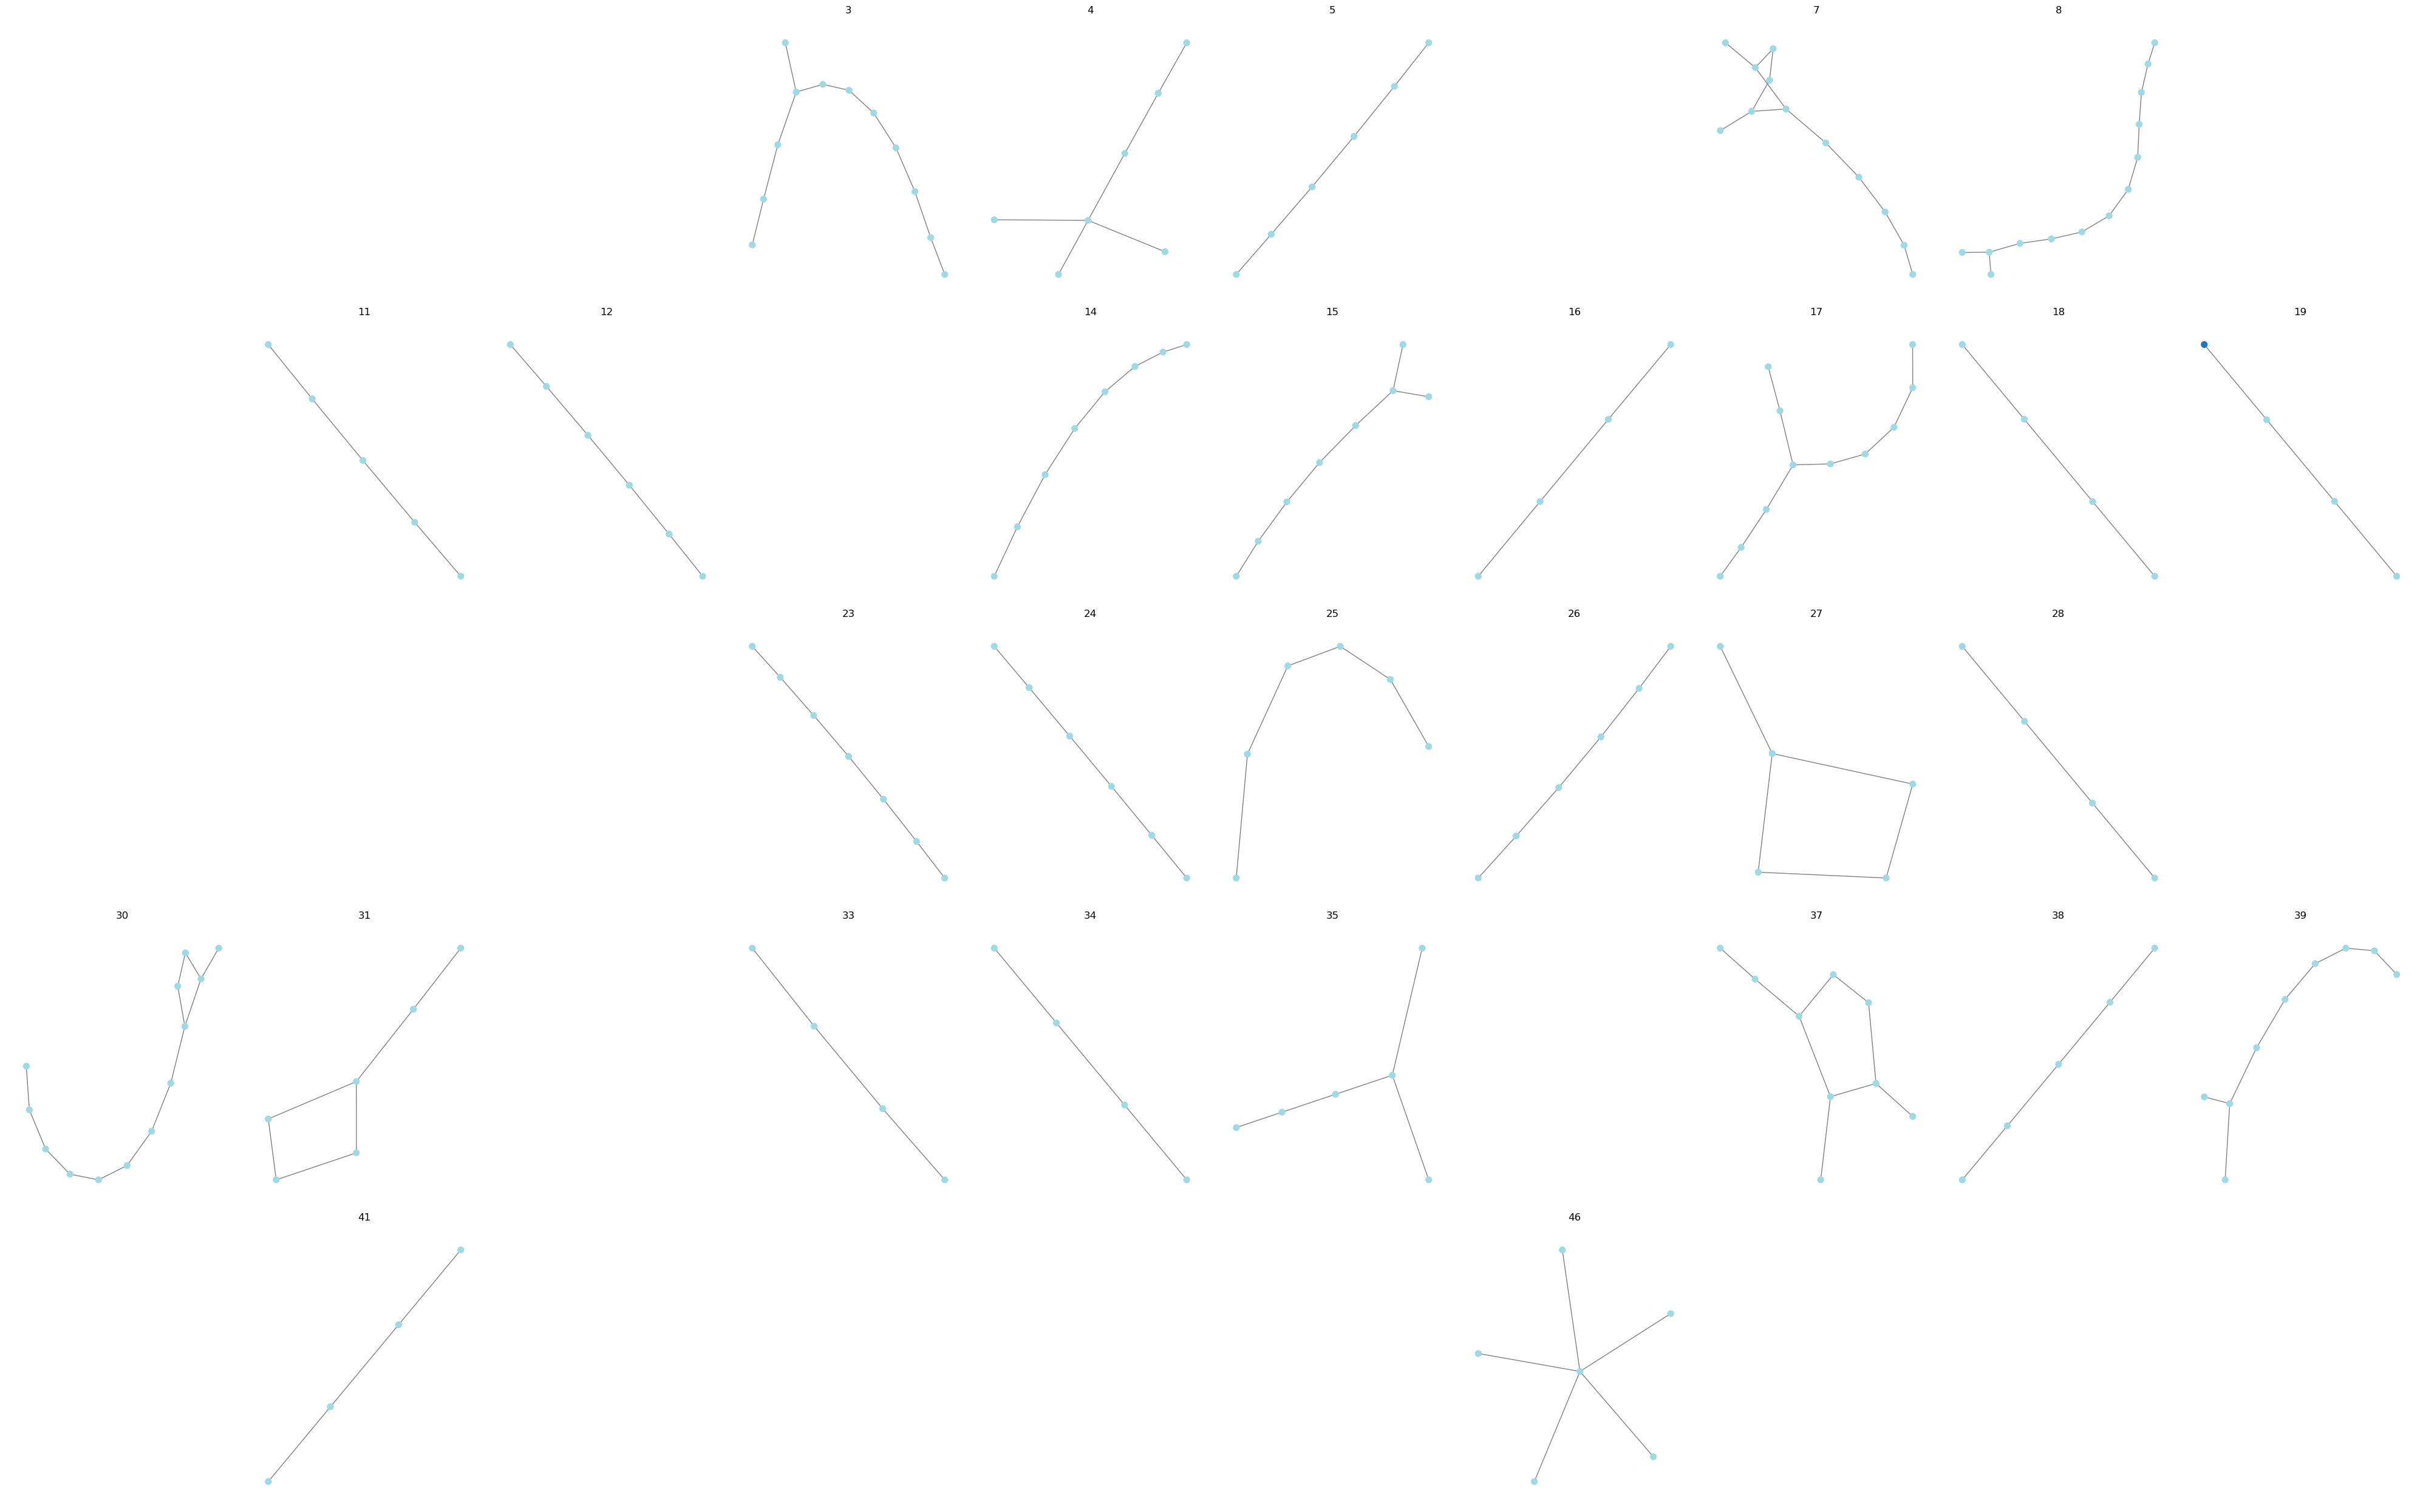

In [57]:
num_clusters = len(component_classes)
cols = 10
rows = (num_clusters // cols) + (num_clusters % cols > 0)

plt.figure(figsize=(40, 5 * rows))
highlighted_node = "SVgr_3_id_50111|2794"

for i, cluster_nodes in enumerate(component_nodes):
    if component_classes[i] == 'Helitron':
        continue
    # print(cluster_nodes)
    plt.subplot(rows, cols, i + 1)
    G_sub = G_not_full.subgraph(cluster_nodes).copy()
    # print(len(G_sub.nodes))
    pos = nx.spring_layout(G_sub)
    node_colors_sub = [fam_to_color[node_family_dict[node]] for node in G_sub.nodes]
    
    
    if highlighted_node in G_sub.nodes:
        node_colors_sub = [
            'red' if node == highlighted_node else node_colors_sub[j]
            for j, node in enumerate(G_sub.nodes)
        ]
        node_sizes_sub = [
            200 if node == highlighted_node else 50
            for node in G_sub.nodes
        ]
        print('found', i)
    else:
        node_sizes_sub = [50] * len(G_sub.nodes)
        
        
        
    nx.draw(
        G_sub, 
        pos, 
        with_labels=False, 
        node_color=node_colors_sub, 
        edge_color='gray', 
        node_size=node_sizes_sub, 
        font_size=1
    )
    plt.title(i)

plt.tight_layout()
plt.show()

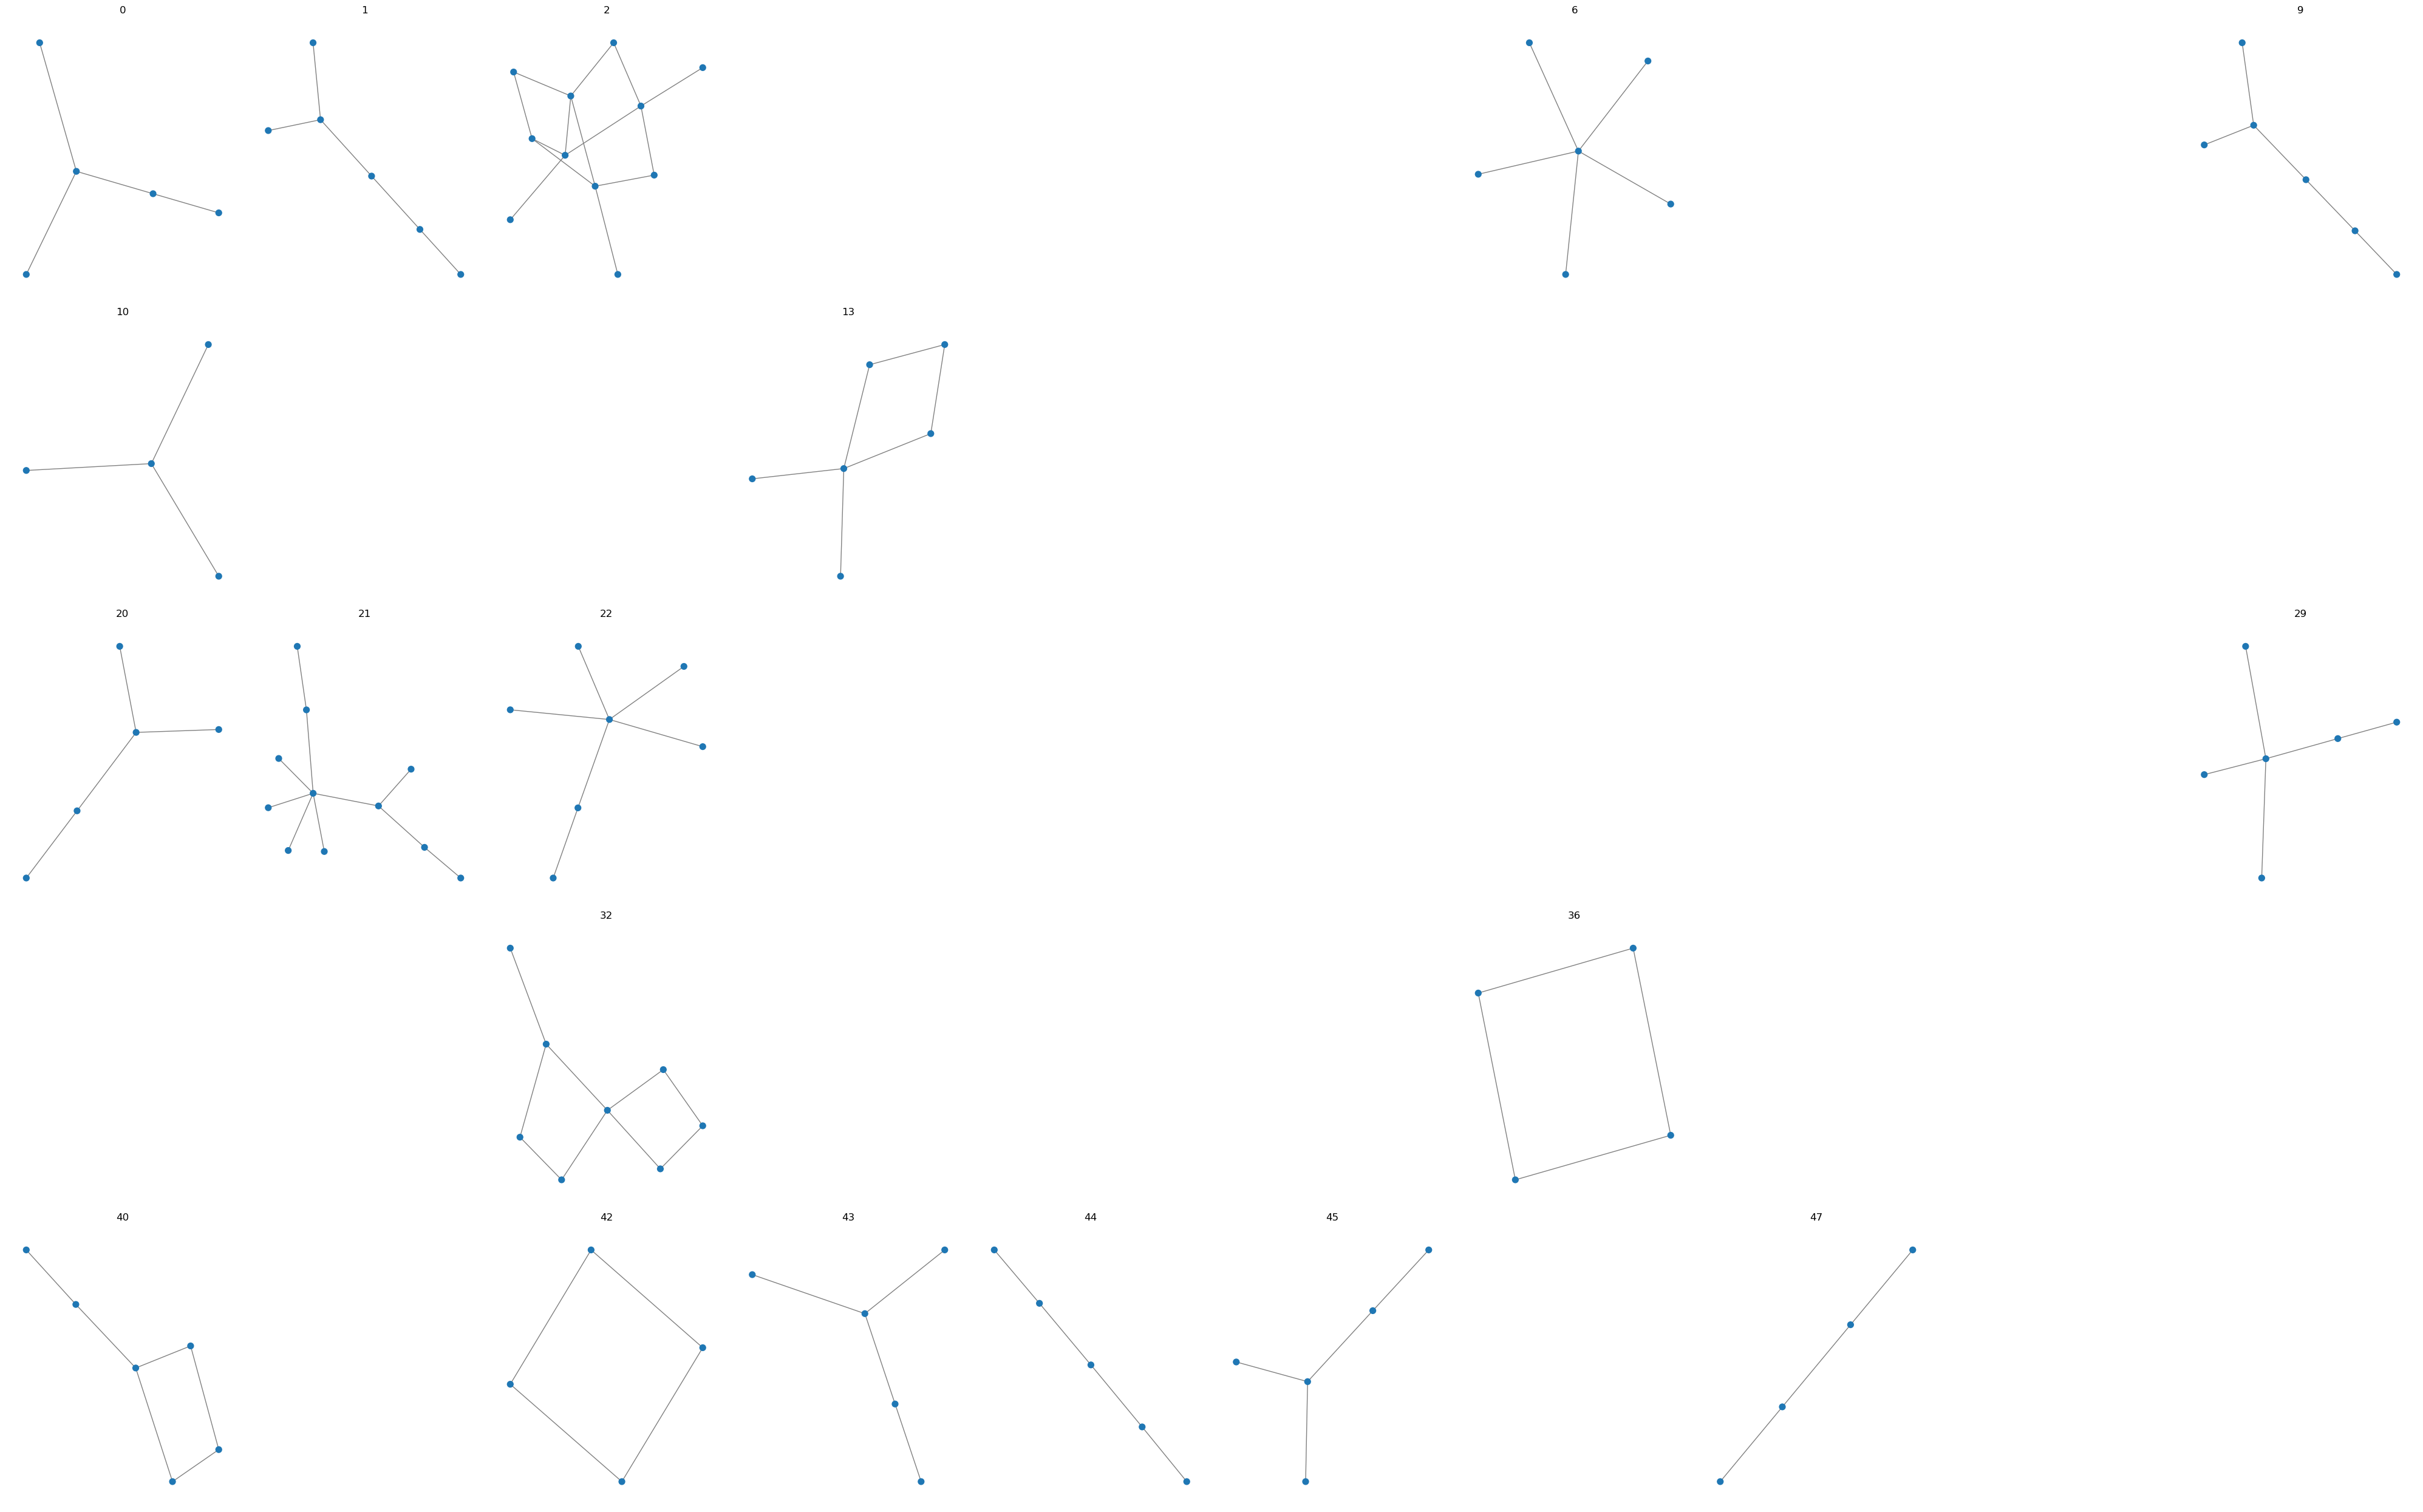

In [58]:
num_clusters = len(component_classes)
cols = 10
rows = (num_clusters // cols) + (num_clusters % cols > 0)

plt.figure(figsize=(40, 5 * rows))
highlighted_node = "SVgr_3_id_50111|2794"

for i, cluster_nodes in enumerate(component_nodes):
    if component_classes[i] == 'LINE':
        continue
    # print(cluster_nodes)
    plt.subplot(rows, cols, i + 1)
    G_sub = G_not_full.subgraph(cluster_nodes).copy()
    # print(len(G_sub.nodes))
    pos = nx.spring_layout(G_sub)
    node_colors_sub = [fam_to_color[node_family_dict[node]] for node in G_sub.nodes]
    
    
    if highlighted_node in G_sub.nodes:
        node_colors_sub = [
            'red' if node == highlighted_node else node_colors_sub[j]
            for j, node in enumerate(G_sub.nodes)
        ]
        node_sizes_sub = [
            200 if node == highlighted_node else 50
            for node in G_sub.nodes
        ]
        print('found', i)
    else:
        node_sizes_sub = [50] * len(G_sub.nodes)
        
        
        
    nx.draw(
        G_sub, 
        pos, 
        with_labels=False, 
        node_color=node_colors_sub, 
        edge_color='gray', 
        node_size=node_sizes_sub, 
        font_size=1
    )
    plt.title(i)

plt.tight_layout()
plt.show()

In [69]:
len(component_nodes[30])

27

found 30


Text(0.5, 1.0, 'LINE')

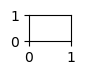

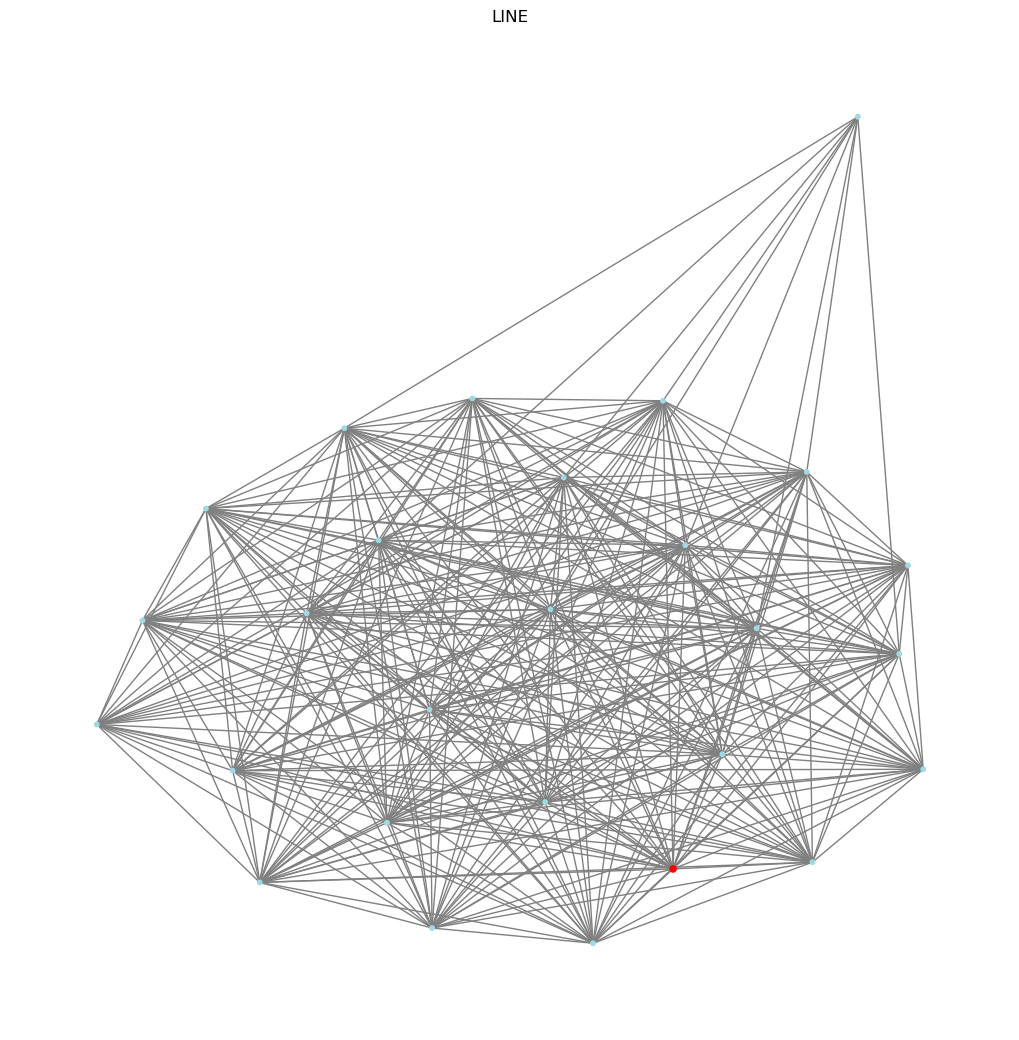

In [71]:
i = 30
cluster_nodes = component_nodes[30]
plt.subplot(rows, cols, i + 1)
G_sub = G_not_full.subgraph(cluster_nodes).copy()
# print(len(G_sub.nodes))
pos = nx.spring_layout(G_sub)
node_colors_sub = [fam_to_color[node_family_dict[node]] for node in G_sub.nodes]


if highlighted_node in G_sub.nodes:
    node_colors_sub = [
        'red' if node == highlighted_node else node_colors_sub[j]
        for j, node in enumerate(G_sub.nodes)
    ]
    node_sizes_sub = [
        20 if node == highlighted_node else 10
        for node in G_sub.nodes
    ]
    print('found', i)
else:
    node_sizes_sub = [10] * len(G_sub.nodes)
    
    
plt.figure(figsize=(10, 10)) 
nx.draw(
    G_sub, 
    pos, 
    with_labels=False, 
    node_color=node_colors_sub, 
    edge_color='gray', 
    node_size=node_sizes_sub, 
    font_size=1
)
plt.title(component_classes[i])

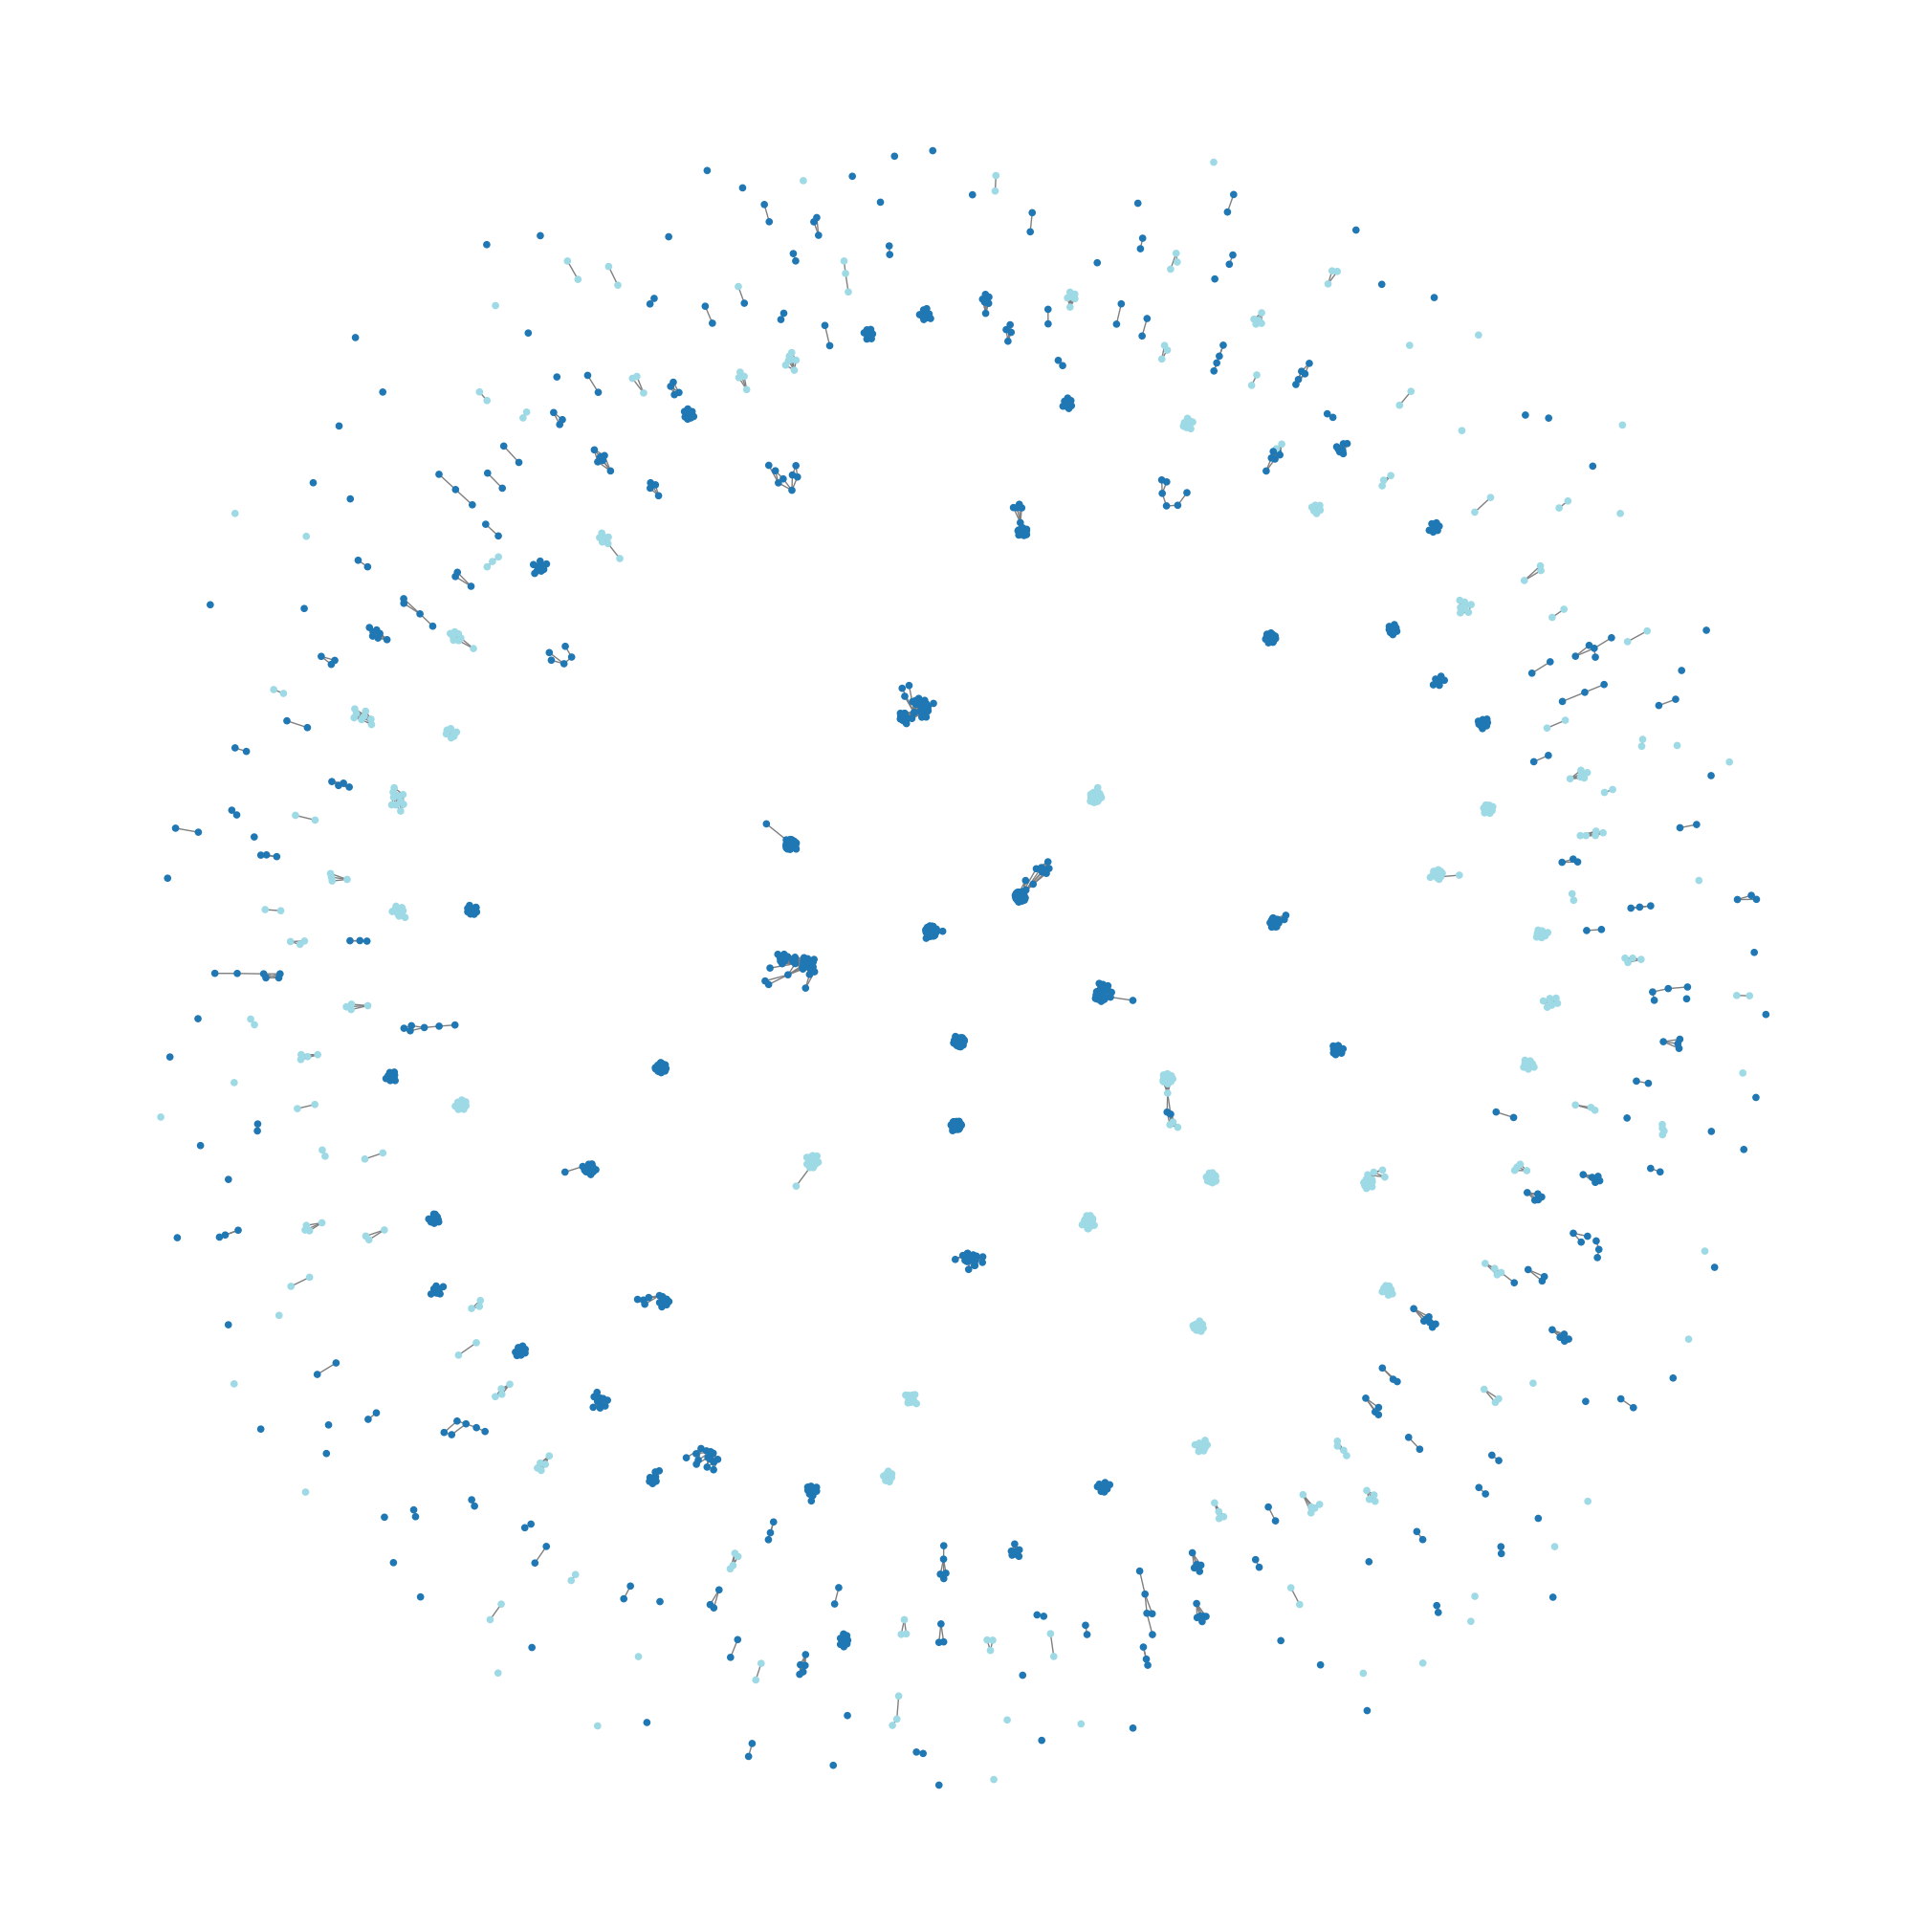

In [51]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G_not_full)
nx.draw(G_not_full, pos, with_labels=False, node_color=node_colors, edge_color='gray', node_size=20, font_size=1)

plt.show()
        

In [36]:
nodes_train, nodes_test, classes_train, classes_test = train_test_split(component_nodes, component_classes, test_size=0.3, random_state=42)
X_train, X_test = [], []
y_train, y_test = [], []

for component, component_label in zip(nodes_train, classes_train):
    embedding = None
    for node in component:
        # print('node:', type(node_embeddings[str(node)]))
        if str(node) in node_embeddings:
            # print(len(np.array(node_embeddings[str(node)]).flatten()))
            if embedding is None:
                embedding = np.array(node_embeddings[str(node)]).flatten()
            else:
                embedding = np.minimum(embedding, np.array(node_embeddings[str(node)]).flatten())
    X_train.append(embedding)  # Добавляем эмбеддинги узла
    y_train.append(component_label)  # Метка компоненты

for component, component_label in zip(nodes_test, classes_test):
    embedding = None
    for node in component:
        # print('node:', type(node_embeddings[str(node)]))
        if str(node) in node_embeddings:
            # print(len(np.array(node_embeddings[str(node)]).flatten()))
            if embedding is None:
                embedding = np.array(node_embeddings2[str(node)]).flatten()
            else:
                embedding = np.minimum(embedding, np.array(node_embeddings2[str(node)]).flatten())
    X_test.append(embedding)  # Добавляем эмбеддинг узла
    y_test.append(component_label)  # Метка компоненты

In [41]:
nodes_train, nodes_test, classes_train, classes_test = train_test_split(component_nodes, component_classes, test_size=0.3, random_state=42)

X_train, X_test = [], []
y_train, y_test = [], []

for component, component_label in zip(nodes_train, classes_train):
    G_sub = G_not_full.subgraph(component).copy()
    degrees = [deg for _, deg in G_sub.degree()]
    mean_degree = sum(degrees) / len(degrees) if len(degrees) > 0 else 0
    
    number_nodes = len(G_sub.nodes())
    
    
    
    embedding = [mean_degree, number_nodes]
    X_train.append(embedding)  # Добавляем эмбеддинги узла
    y_train.append(component_label)  # Метка компоненты

for component, component_label in zip(nodes_test, classes_test):
    G_sub = G_not_full.subgraph(component).copy()
    degrees = [deg for _, deg in G_sub.degree()]
    mean_degree = sum(degrees) / len(degrees) if len(degrees) > 0 else 0
    
    number_nodes = len(G_sub.nodes())
    embedding = [mean_degree, number_nodes]
    X_train.append(embedding)  # Добавляем эмбеддинги узла
    y_train.append(component_label)  # Метка компоненты

In [42]:
print(len(y_train), y_train.count('Helitron'), y_train.count('LINE'))


48 19 29


In [43]:
np.array(X_train).shape

(48, 2)

/Users/nad/miniconda3/envs/sna/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


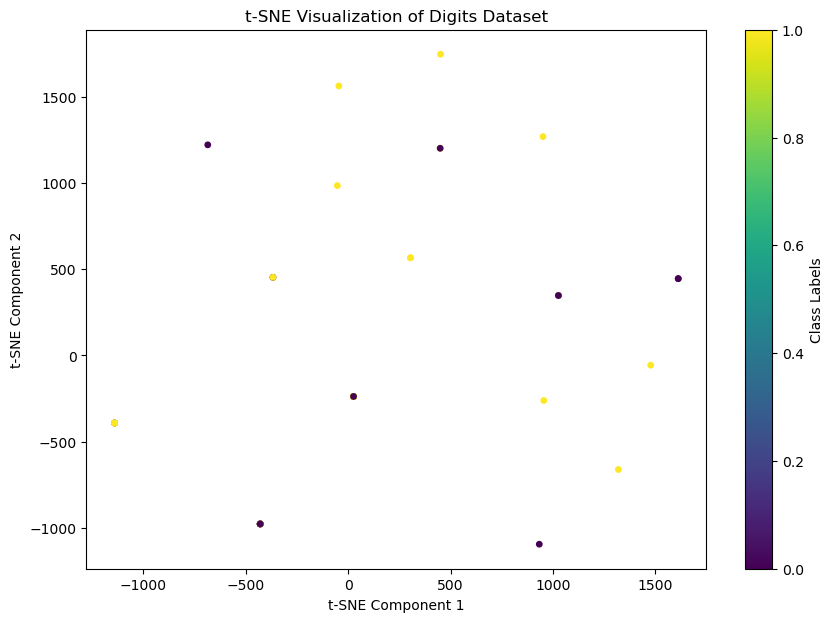

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

X = X_train
y = y_train

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# 2. Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Применение t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_encoded, cmap='viridis', s=15)
plt.colorbar(scatter, label='Class Labels')
plt.title("t-SNE Visualization of Digits Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [56]:
y_encoded[22], y_encoded[23], y_encoded[25], y_encoded[26]

(1, 0, 1, 0)

In [53]:
X_embedded

array([[ 1027.0408  ,   348.14697 ],
       [  449.44464 ,  1202.9928  ],
       [ -429.70935 ,  -978.33167 ],
       [  304.4468  ,   567.43195 ],
       [   26.347029,  -238.05046 ],
       [-1140.7589  ,  -392.10428 ],
       [   26.347029,  -238.05046 ],
       [ -685.6827  ,  1223.0492  ],
       [   26.347029,  -238.05046 ],
       [ -429.70935 ,  -978.33167 ],
       [ 1027.0408  ,   348.14697 ],
       [  451.2342  ,  1749.2144  ],
       [   26.347029,  -238.05046 ],
       [ -429.70935 ,  -978.33167 ],
       [-1140.7589  ,  -392.10428 ],
       [   26.347029,  -238.05046 ],
       [ -429.70935 ,  -978.33167 ],
       [  449.44464 ,  1202.9928  ],
       [  933.48193 , -1096.1019  ],
       [ 1612.0911  ,   446.06372 ],
       [   26.347029,  -238.05046 ],
       [ -367.11456 ,   453.8187  ],
       [-1140.7589  ,  -392.10428 ],
       [-1140.7589  ,  -392.10428 ],
       [ -367.11456 ,   453.8187  ],
       [-1140.7589  ,  -392.10428 ],
       [-1140.7589  ,  -392.10428 ],
 

In [52]:
unique_rows = np.unique(X_embedded, axis=0)
print(unique_rows)

[[-1140.7589    -392.10428 ]
 [ -685.6827    1223.0492  ]
 [ -429.70935   -978.33167 ]
 [ -367.11456    453.8187  ]
 [  -52.939114   986.39044 ]
 [  -45.16692   1564.9131  ]
 [   26.347029  -238.05046 ]
 [  304.4468     567.43195 ]
 [  449.44464   1202.9928  ]
 [  451.2342    1749.2144  ]
 [  933.48193  -1096.1019  ]
 [  951.8188    1270.7543  ]
 [  955.41626   -261.75357 ]
 [ 1027.0408     348.14697 ]
 [ 1319.9302    -662.2199  ]
 [ 1477.7266     -56.498302]
 [ 1612.0911     446.06372 ]]


In [40]:
# Обучение классификатора
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

data = pd.DataFrame({'Array1': y_test, 'Array2': y_pred})

# Создание таблицы сопряжённости
contingency_table = pd.crosstab(data['Array1'], data['Array2'])

print(contingency_table)

              precision    recall  f1-score   support

    Helitron       0.20      1.00      0.33         3
        LINE       0.00      0.00      0.00        12

    accuracy                           0.20        15
   macro avg       0.10      0.50      0.17        15
weighted avg       0.04      0.20      0.07        15

Array2    Helitron
Array1            
Helitron         3
LINE            12


/Users/nad/miniconda3/envs/sna/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nad/miniconda3/envs/sna/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nad/miniconda3/envs/sna/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r